In [2]:
%pip install numpy --upgrade

  Using cached numpy-1.24.3-cp39-cp39-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\abdul\\anaconda3\\Lib\\site-packages\\~~mpy\\.libs\\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

c:\Users\abdul\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_dir = pathlib.Path("Dataset/") / "data"

In [3]:
emotions = np.array(tf.io.gfile.listdir(str(data_dir)))
emotions = emotions[emotions != 'README.md']
print('Emotions:', emotions)

Emotions: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
labels = tf.data.Dataset.from_tensor_slices(filenames).map(map_func=get_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
for folder in os.listdir(data_dir):
    print('Number of {} examples: {}'.format(folder, len(os.listdir(data_dir / folder))))
print([label for label in labels.take(8)])

NameError: name 'get_label' is not defined

In [44]:
for filename in filenames:
    print(filename)

tf.Tensor(b'Dataset\\data\\neutral\\YAF_ditch_neutral.wav', shape=(), dtype=string)
tf.Tensor(b'Dataset\\data\\surprise\\OAF_shirt_ps.wav', shape=(), dtype=string)
tf.Tensor(b'Dataset\\data\\surprise\\YAF_shall_ps.wav', shape=(), dtype=string)
tf.Tensor(b'Dataset\\data\\fear\\YAF_mess_fear.wav', shape=(), dtype=string)
tf.Tensor(b'Dataset\\data\\disgust\\1013_IWW_DIS_XX.wav', shape=(), dtype=string)
tf.Tensor(b'Dataset\\data\\fear\\03-01-06-01-01-02-04.wav', shape=(), dtype=string)
tf.Tensor(b'Dataset\\data\\sad\\1033_MTI_SAD_XX.wav', shape=(), dtype=string)
tf.Tensor(b'Dataset\\data\\sad\\03-01-04-02-01-02-20.wav', shape=(), dtype=string)
tf.Tensor(b'Dataset\\data\\angry\\1052_IOM_ANG_XX.wav', shape=(), dtype=string)
tf.Tensor(b'Dataset\\data\\fear\\1038_DFA_FEA_XX.wav', shape=(), dtype=string)
tf.Tensor(b'Dataset\\data\\sad\\03-01-04-02-02-01-24.wav', shape=(), dtype=string)
tf.Tensor(b'Dataset\\data\\neutral\\DC_n20.wav', shape=(), dtype=string)
tf.Tensor(b'Dataset\\data\\disgust\\1

In [5]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 50000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [50000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [8]:
# Create dataset for training
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(filenames)

for data in files_ds.take(1):
    print(data)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)
for data in waveform_ds.take(1):
    print(data)

tf.Tensor(b'Dataset\\data\\fear\\1002_IOM_FEA_XX.wav', shape=(), dtype=string)
(<tf.Tensor: shape=(41642,), dtype=float32, numpy=
array([ 0.00085449,  0.00021362, -0.00024414, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)>, <tf.Tensor: shape=(), dtype=string, numpy=b'fear'>)


In [7]:
n = 0
import wave
for data in files_ds.take(40):
    # pass
    # audio_binary = tf.io.read_file(data)
    # print(data)
    # waveform = decode_audio(audio_binary)
    print(data.numpy())
    with wave.open(data.numpy().decode(), 'r') as fin:
        header_fsize = (fin.getnframes() * fin.getnchannels() * fin.getsampwidth()) + 44
    file_fsize = os.path.getsize(data.numpy().decode())
    print(header_fsize-file_fsize)
    print(header_fsize != file_fsize)

b'Dataset\\data\\neutral\\1036_TSI_NEU_XX.wav'
0
False
b'Dataset\\data\\angry\\1055_TAI_ANG_XX.wav'
0
False
b'Dataset\\data\\fear\\1031_IOM_FEA_XX.wav'
0
False
b'Dataset\\data\\angry\\YAF_far_angry.wav'
0
False
b'Dataset\\data\\neutral\\1066_MTI_NEU_XX.wav'
0
False
b'Dataset\\data\\angry\\1045_IWL_ANG_XX.wav'
0
False
b'Dataset\\data\\angry\\1078_IEO_ANG_MD.wav'
0
False
b'Dataset\\data\\sad\\YAF_far_sad.wav'
0
False
b'Dataset\\data\\happy\\1076_ITS_HAP_XX.wav'
0
False
b'Dataset\\data\\fear\\1077_IEO_FEA_HI.wav'
0
False
b'Dataset\\data\\happy\\1075_MTI_HAP_XX.wav'
0
False
b'Dataset\\data\\happy\\1046_IEO_HAP_MD.wav'
0
False
b'Dataset\\data\\angry\\1062_ITH_ANG_XX.wav'
0
False
b'Dataset\\data\\neutral\\1006_MTI_NEU_XX.wav'
0
False
b'Dataset\\data\\fear\\1084_IWL_FEA_XX.wav'
0
False
b'Dataset\\data\\disgust\\1024_TAI_DIS_XX.wav'
0
False
b'Dataset\\data\\angry\\1002_TIE_ANG_XX.wav'
0
False
b'Dataset\\data\\neutral\\YAF_soap_neutral.wav'
0
False
b'Dataset\\data\\angry\\YAF_dead_angry.wav'
0


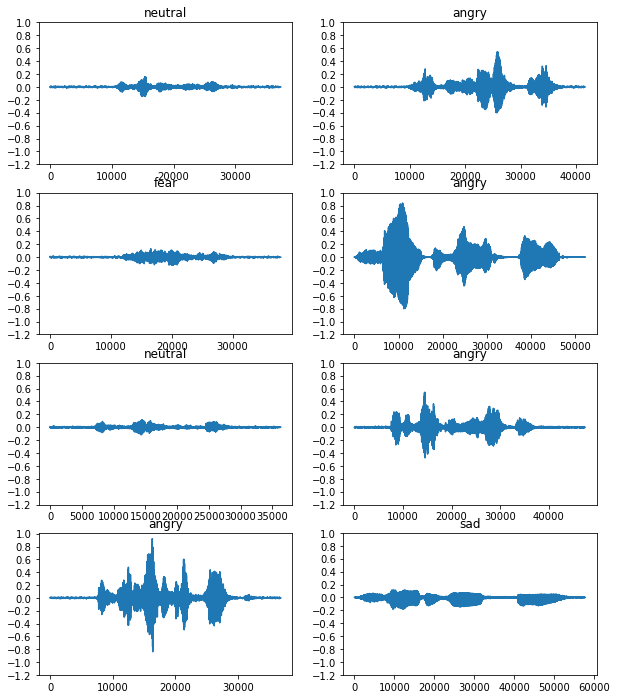

In [8]:
# Show waveform
rows = 4
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [9]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: neutral
Waveform shape: (37371,)
Spectrogram shape: (389, 129, 1)
Audio playback


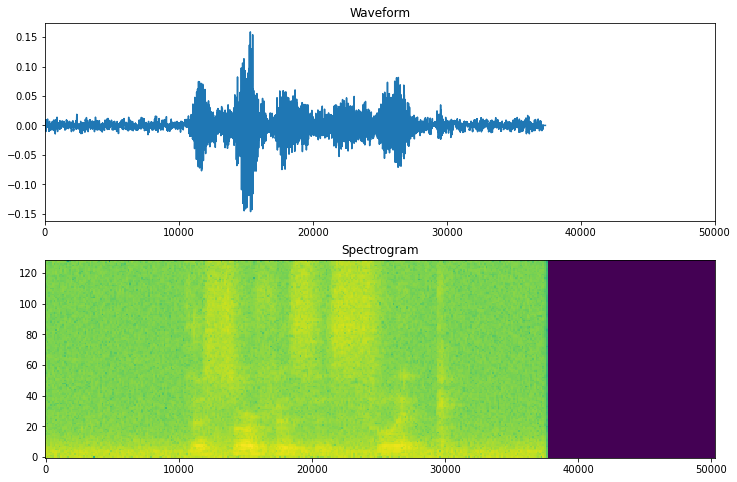

In [10]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 50000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [11]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == emotions)
  return spectrogram, label_id

In [12]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

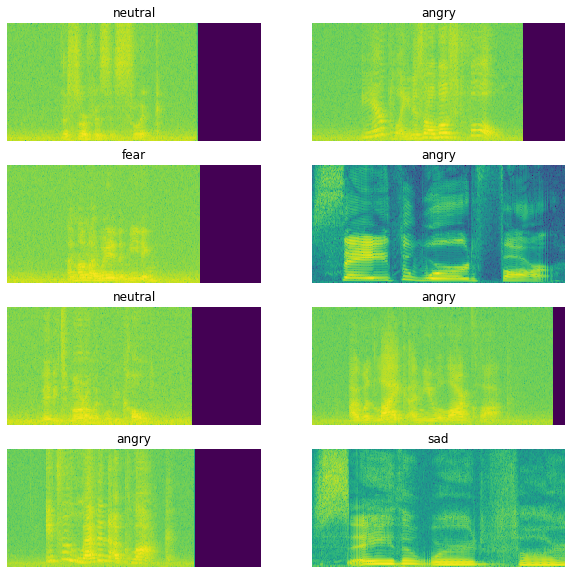

In [13]:
rows = 4
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(emotions[label_id.numpy()])
  ax.axis('off')

plt.show()

In [14]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [15]:
train_files = filenames[:7385]
val_files = filenames[7385: 7385 + 923]
test_files = filenames[-923:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 7385
Validation set size 923
Test set size 923


In [16]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [17]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [18]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [22]:

for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(emotions)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
# norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
#     norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (64, 389, 129, 1)


ValueError: Exception encountered when calling layer "resizing" (type Resizing).

'images' must have either 3 or 4 dimensions.

Call arguments received by layer "resizing" (type Resizing):
  • inputs=tf.Tensor(shape=(None, 64, 389, 129, 1), dtype=float32)

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

NameError: name 'model' is not defined

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)